In [10]:
from zlib import crc32
import numpy as np

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'},
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'},
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'},
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'},
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'},
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия',
                          'Перцептрон',
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия',
                              'Перцептрон',
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна',
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()

task

{'mail': 'l;km',
 'id': 3447730783,
 'type': np.str_('regression'),
 'dataset': {'name': 'Servo Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'},
 'method': ['Линейная регрессия', 'Перцептрон', 'SVR']}

In [11]:
from sklearn import datasets, model_selection
import pandas as pd

dataset = datasets.load_breast_cancer()
train_features, test_features, train_labels, test_labels = model_selection.train_test_split(dataset.data,
                                                                                            dataset.target,
                                                                                            test_size=0.1)

df = pd.DataFrame(data=train_features, columns=dataset.feature_names)
df.insert(0, "diagnosis", np.vectorize(lambda x: dataset.target_names[x])(train_labels))

print(dataset.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Рассмотрим количество представителей каждого класса

In [12]:
df.value_counts(df["diagnosis"])

diagnosis
benign       320
malignant    192
Name: count, dtype: int64

Датасет разбалансирован, но не сильно (соотношение классов примерно 60/40)

Исследуем корелляцию между средними значениями параметров датасета

<Axes: >

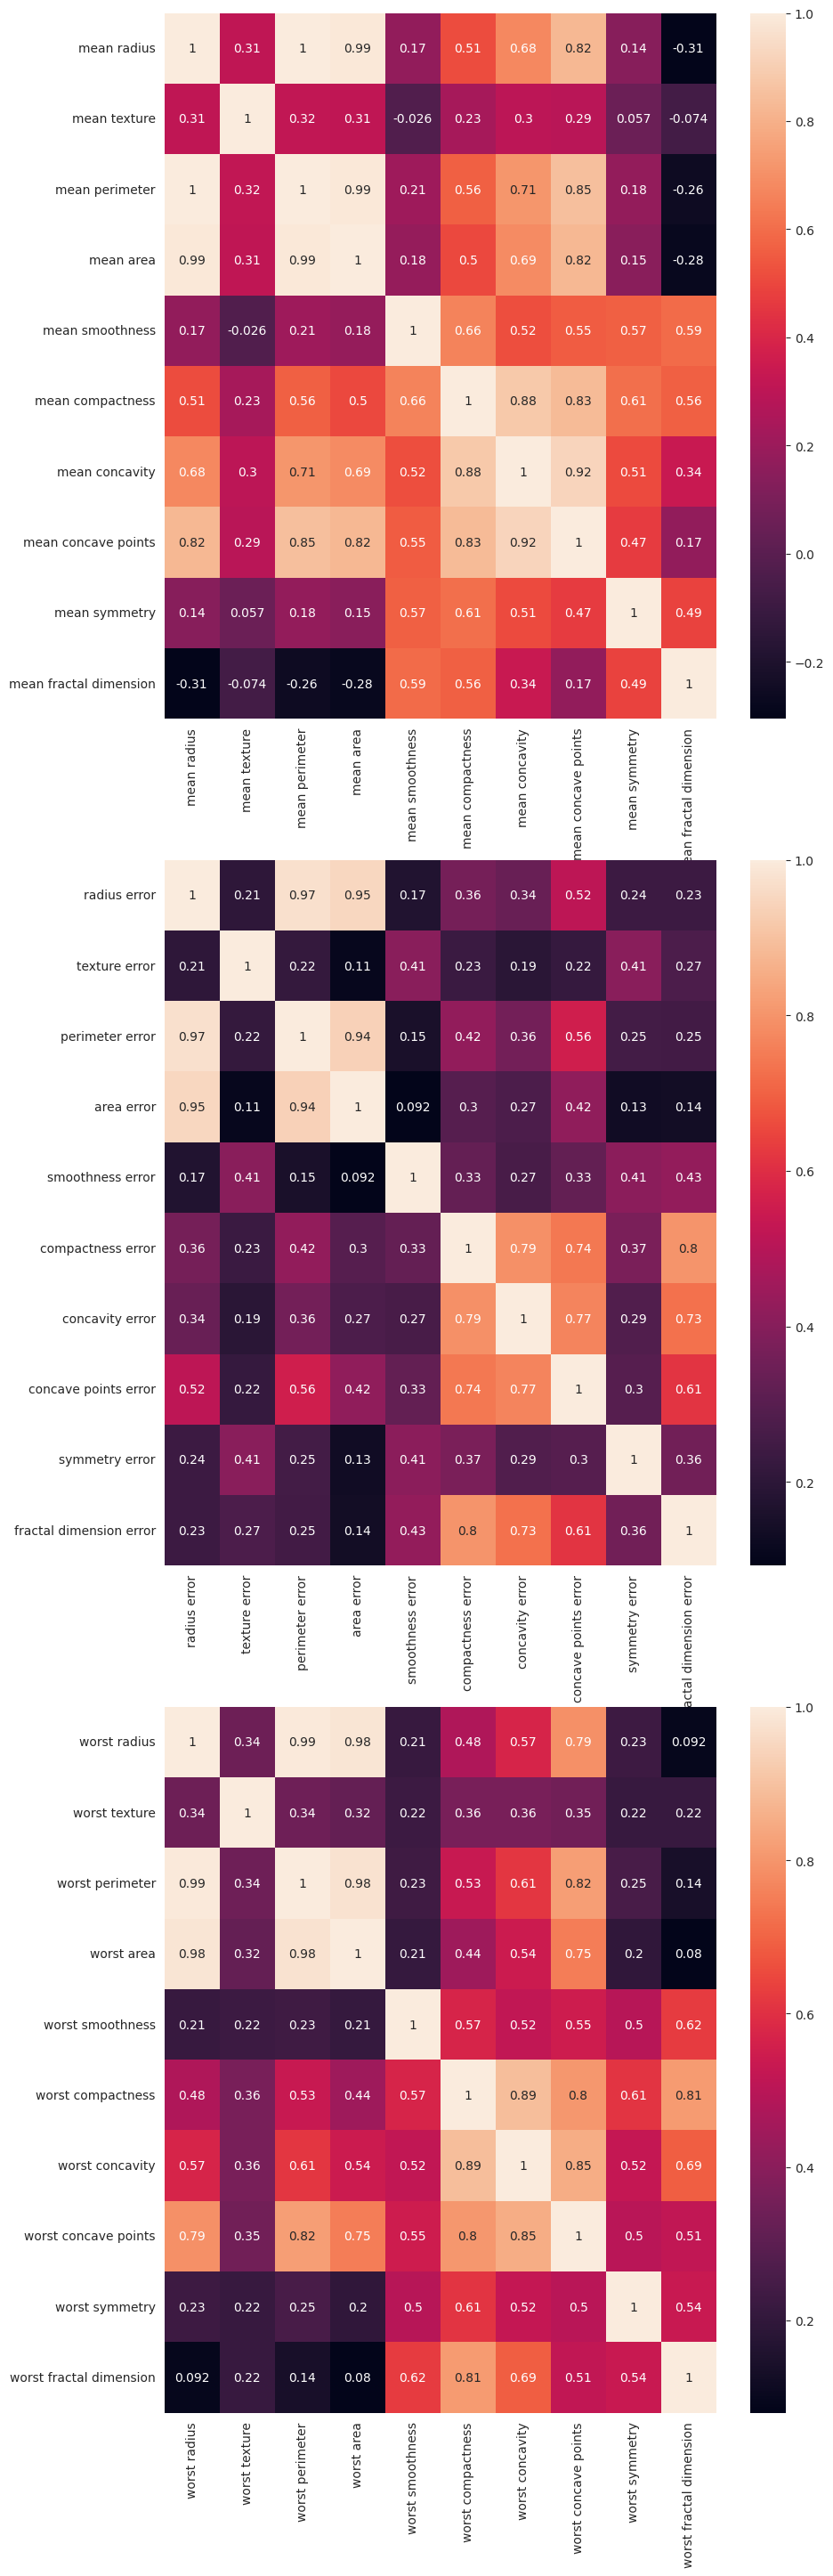

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, figsize=(10, 35))
sns.heatmap(df[dataset.feature_names[0:10]].corr(), annot=True, ax=axs[0])
sns.heatmap(df[dataset.feature_names[10:20]].corr(), annot=True, ax=axs[1])
sns.heatmap(df[dataset.feature_names[20:30]].corr(), annot=True, ax=axs[2])

Заметим, что есть 2 группы сильно скореллированных параметров: \[`radius`, `perimeter`, `area`\] и \[`compactness`, `concavity`, `concave points`\]. Оставим из каждой группы по 1 параметру, наиболее скореллированному со всеми остальными.

In [14]:
features_to_drop = ["perimeter", "area", "compactness", "concave points"]
columns_to_drop = [idx for idx, name in enumerate(dataset.feature_names)
                   if any(feature_name in name for feature_name in features_to_drop)]
df.drop(columns=dataset.feature_names[columns_to_drop], inplace=True)

Проверим, что не осталось сильно скореллированных пар параметров

<Axes: >

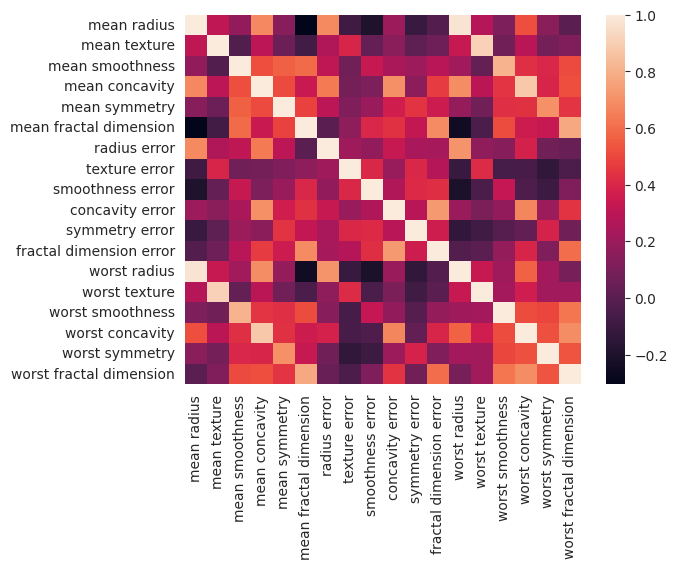

In [15]:
sns.heatmap(df.drop(columns="diagnosis").corr())

Все еще есть отедьные пары относительно сильно скореллированных средних и худших значений одного и того же параметра в случае малого отклонения, но такие корелляции проигнорируем.

Посмотрим распределения параметров в зависимости от от класса:

/tmp/ipykernel_2696/1843174007.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2696/1843174007.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2696/1843174007.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2696/1843174007.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2696/1843174007.py:9: UserWarning: No artists with labels found to put in legend.  Note that arti

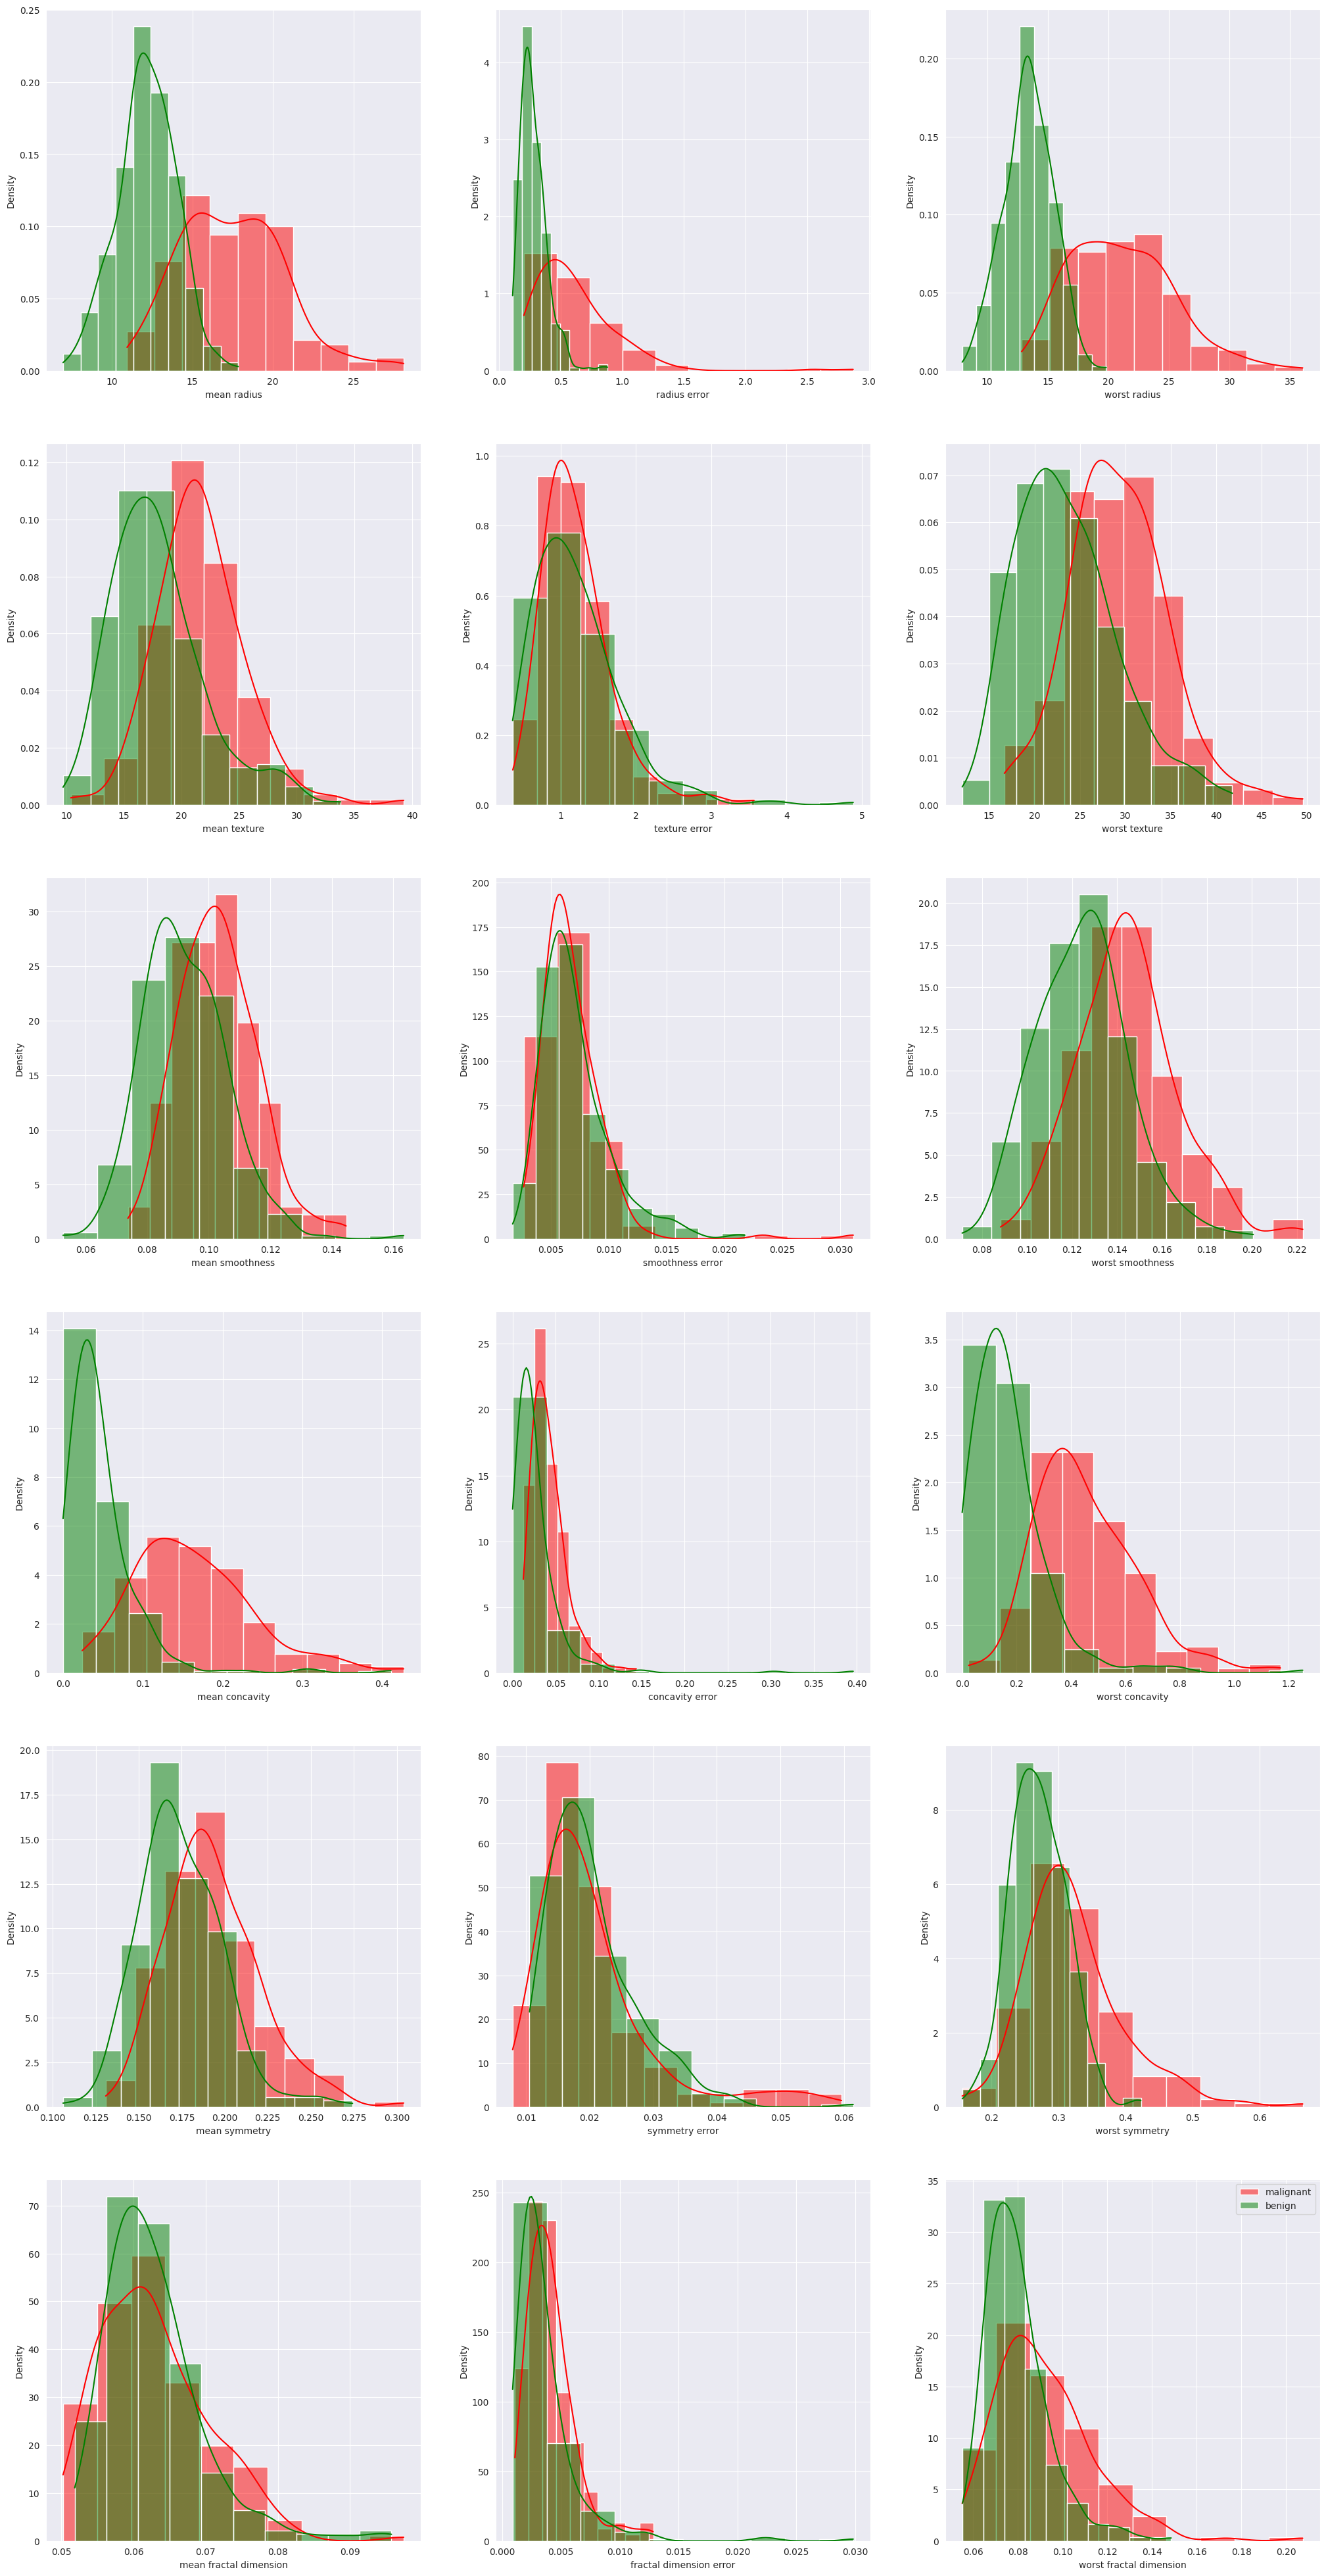

In [17]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(25, 50))
for idx, col in enumerate(df.drop(columns="diagnosis").columns):
    for diagnosis in dataset.target_names:
        sns.histplot(df[df["diagnosis"] == diagnosis][col], bins=10,
                     color="green" if diagnosis == "benign" else "red",
                     label=diagnosis, stat="density", kde=True,
                     ax=axs[idx % 6][idx // 6])

        plt.legend()